In [2]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import libpysal as lps
import geopandas as gpd
from esda.moran import Moran
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from libpysal.weights.contiguity import Queen

### **Voting Data**

#### Reading and Initial Filtering/Cleaning of the Data

In [3]:
# Reads the data
votacao_secao_2022 = pd.read_csv(
    "./data/votacao_secao_2022_PR.csv", sep=";", encoding="latin-1"
)

In [4]:
# Filters only the desired data

## DS_CARGO must be DEPUTADO ESTADUAL
votacao_secao_2022 = votacao_secao_2022[
    votacao_secao_2022["DS_CARGO"] == "DEPUTADO ESTADUAL"
]

## Only these columns are of interest
columns = [
    "CD_MUNICIPIO",
    "NM_MUNICIPIO",
    "NR_ZONA",
    "NR_SECAO",
    "NR_VOTAVEL",
    "NM_VOTAVEL",
    "QT_VOTOS",
    "SQ_CANDIDATO",
    "NR_LOCAL_VOTACAO",
    "NM_LOCAL_VOTACAO",
    "DS_LOCAL_VOTACAO_ENDERECO",
]
votacao_secao_2022 = votacao_secao_2022[columns]

In [5]:
# Maps the CD_MUNICIPIO to another format
with open("./data/mapa-cod-municipio.csv", mode="r") as infile:
    reader = csv.reader(infile)
    code_mapping = {int(rows[1]): int(rows[0]) for rows in reader}
votacao_secao_2022["CD_MUNICIPIO"] = votacao_secao_2022["CD_MUNICIPIO"].map(
    code_mapping
)

In [6]:
# Checks if there are any missing values
votacao_secao_2022[votacao_secao_2022.isna().any(axis=1)]

,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,SQ_CANDIDATO,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO


In [7]:
# Checks for missing values based on the database's encoding

## Text values
text_columns = [
    "NM_MUNICIPIO",
    "NM_VOTAVEL",
    "NM_LOCAL_VOTACAO",
    "DS_LOCAL_VOTACAO_ENDERECO",
]
print(
    "Missing Text Values:",
    sum((votacao_secao_2022[text_columns] == "#NULO").any(axis=1))
    + sum((votacao_secao_2022[text_columns] == "#NE").any(axis=1)),
)

## Numeric values
numeric_columns = [
    "CD_MUNICIPIO",
    "NR_ZONA",
    "NR_SECAO",
    "NR_VOTAVEL",
    "QT_VOTOS",
    "SQ_CANDIDATO",
    "NR_LOCAL_VOTACAO",
]
print(
    "Missing Numeric Values:",
    sum((votacao_secao_2022[numeric_columns] < 0).any(axis=1)),
)

Missing Text Values: 0
Missing Numeric Values: 245284


In [8]:
# Showing which columns have missing values
(votacao_secao_2022[numeric_columns] < 0).any(axis=0)

CD_MUNICIPIO        False
NR_ZONA             False
NR_SECAO            False
NR_VOTAVEL          False
QT_VOTOS            False
SQ_CANDIDATO         True
NR_LOCAL_VOTACAO    False
dtype: bool

In [9]:
# Showing entries with missing numeric columns
votacao_secao_2022[(votacao_secao_2022[numeric_columns] < 0).any(axis=1)]

,CD_MUNICIPIO,NM_MUNICIPIO,NR_ZONA,NR_SECAO,NR_VOTAVEL,NM_VOTAVEL,QT_VOTOS,SQ_CANDIDATO,NR_LOCAL_VOTACAO,NM_LOCAL_VOTACAO,DS_LOCAL_VOTACAO_ENDERECO
1933,4106902,CURITIBA,1,209,96,VOTO NULO,9,-1,1317,COLÉGIO ADVENTISTA BOM RETIRO (PARTICULAR),R LYSIMACO FERREIRA DA COSTA 980
1935,4124053,SANTA TEREZINHA DE ITAIPU,147,382,96,VOTO NULO,6,-1,1023,COLEGIO ESTADUAL DOM MANOEL KONNER,"RUA VENANCIO SMANIA, 960"
1936,4106902,CURITIBA,1,390,96,VOTO NULO,5,-1,1937,FUNDACAO DE ESTUDOS SOCIAIS DO PARANA - FESP,R GENERAL CARNEIRO 216
1938,4118204,PARANAGUÁ,5,168,96,VOTO NULO,8,-1,1139,COLEGIO ESTADUAL PROFESSOR VIDAL VANHONI,"RUA MANECO VIANA, S/N"
1940,4128005,UBIRATÃ,98,102,96,VOTO NULO,6,-1,1074,COLÉGIO ESTADUAL QUINTINO BOCAIUVA,"RUA ERNESTO NOVAES DE SOUZA, 636"
...,...,...,...,...,...,...,...,...,...,...,...
3395191,4121802,RIBEIRÃO CLARO,23,4,11,PROGRESSISTAS,1,-3,1015,(GINÁSIO) ESCOLA ESTADUAL DOUTOR JOÃO DA ROCHA...,"RUA MAL. DEODORO DA FONSECA, 908"
3395192,4121802,RIBEIRÃO CLARO,23,4,12,Partido Democrático Trabalhista,1,-3,1015,(GINÁSIO) ESCOLA ESTADUAL DOUTOR JOÃO DA ROCHA...,"RUA MAL. DEODORO DA FONSECA, 908"
3395193,4121802,RIBEIRÃO CLARO,23,4,13,Partido dos Trabalhadores,6,-3,1015,(GINÁSIO) ESCOLA ESTADUAL DOUTOR JOÃO DA ROCHA...,"RUA MAL. DEODORO DA FONSECA, 908"
3395194,4121802,RIBEIRÃO CLARO,23,4,19,Podemos,1,-3,1015,(GINÁSIO) ESCOLA ESTADUAL DOUTOR JOÃO DA ROCHA...,"RUA MAL. DEODORO DA FONSECA, 908"


In [10]:
# Filters out missing values
votacao_secao_2022 = votacao_secao_2022[
    (votacao_secao_2022[numeric_columns] >= 0).all(axis=1)
]

In [11]:
# Database characteristics
votacao_secao_2022.shape

(1332398, 11)

In [12]:
# Saving the processed data
votacao_secao_2022.to_csv("./processed_data/resultados_secao.csv", index=False, sep=";")

#### Exploratory Analysis

In [13]:
# Prints the unique values of each column
for column in votacao_secao_2022.columns:
    print(f"### {column} ###")
    print()

    values, counts = np.unique(votacao_secao_2022[column], return_counts=True)
    unique = dict(zip(values, counts))
    for value, count in unique.items():
        print(str(value) + ": " + str(count))

    print()
    print()

### CD_MUNICIPIO ###

4100103: 635
4100202: 485
4100301: 933
4100400: 14479
4100459: 263
4100509: 2051
4100608: 1375
4100707: 681
4100806: 979
4100905: 413
4101002: 1641
4101051: 239
4101101: 2193
4101150: 257
4101200: 2297
4101309: 563
4101408: 9087
4101507: 11083
4101606: 3283
4101655: 291
4101705: 1563
4101804: 22536
4101853: 192
4101903: 1486
4102000: 2326
4102109: 2762
4102208: 454
4102307: 1758
4102406: 3029
4102505: 1249
4102604: 917
4102703: 234
4102752: 228
4102802: 1510
4102901: 1343
4103008: 309
4103024: 177
4103040: 391
4103057: 700
4103107: 1716
4103156: 250
4103206: 580
4103222: 265
4103305: 834
4103354: 547
4103370: 198
4103404: 179
4103453: 1763
4103479: 298
4103503: 890
4103602: 2228
4103701: 11718
4103800: 745
4103909: 1616
4103958: 234
4104006: 6303
4104055: 410
4104105: 724
4104204: 15728
4104253: 3438
4104303: 8637
4104402: 1275
4104428: 1184
4104451: 1113
4104501: 1836
4104600: 1378
4104659: 1994
4104709: 1528
4104808: 31609
4104907: 5056
4105003: 773
4105102: 104

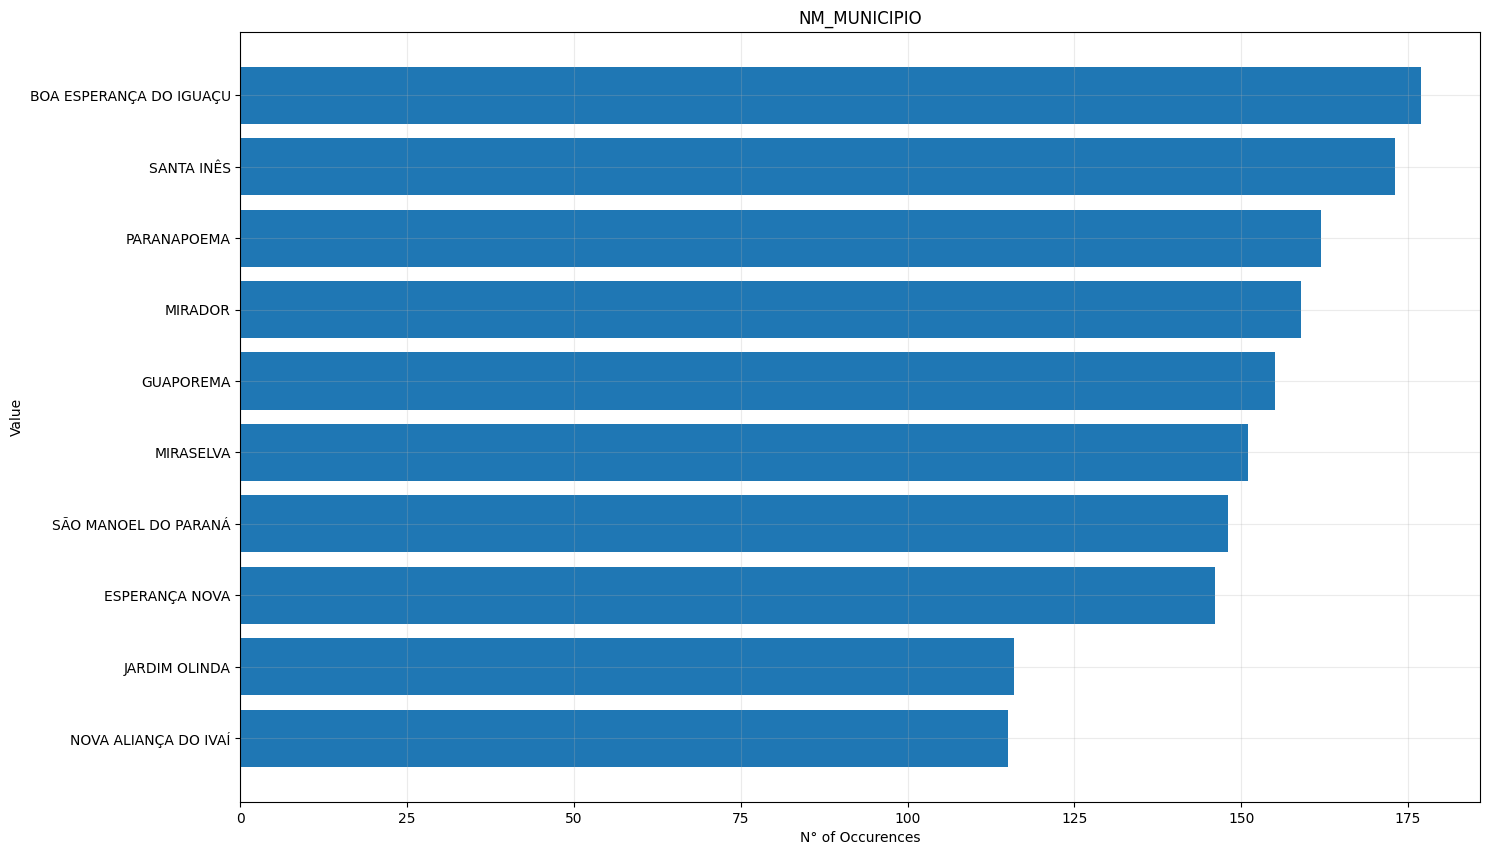

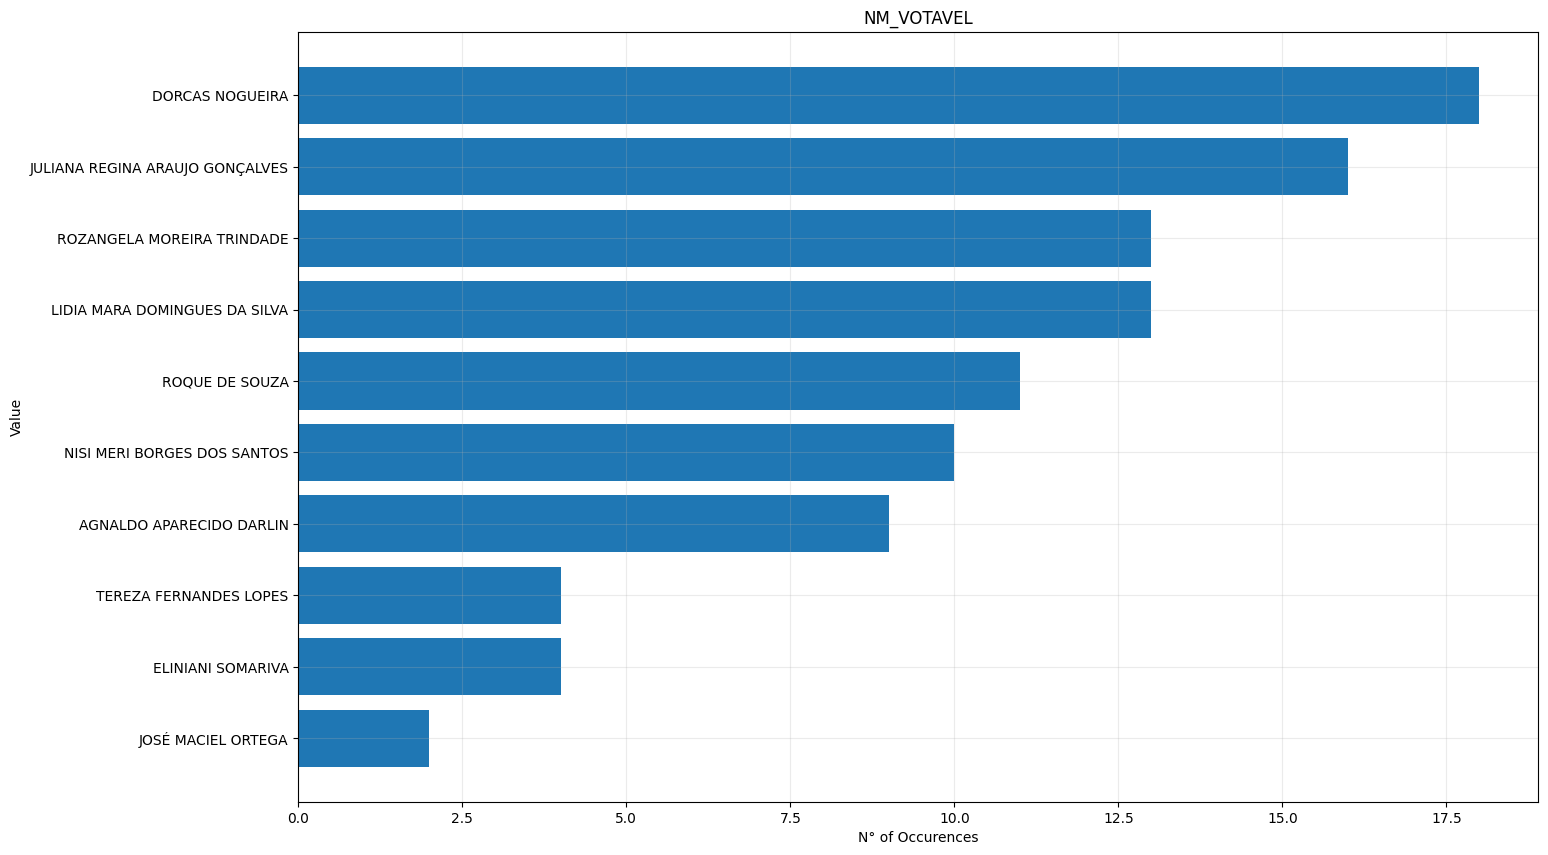

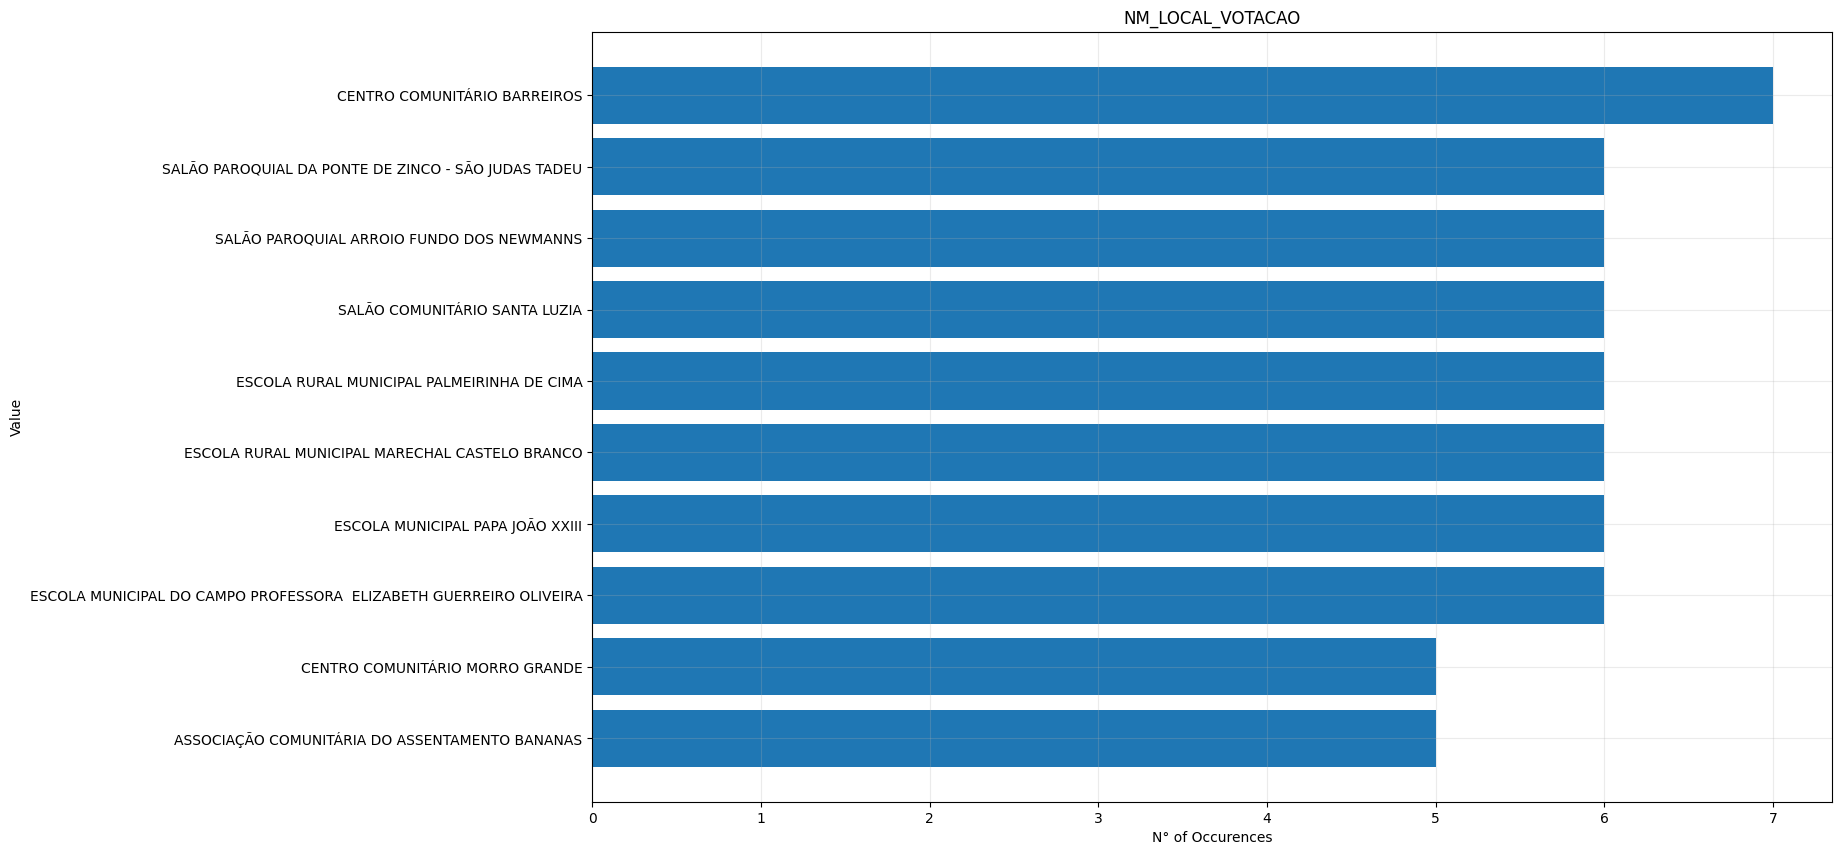

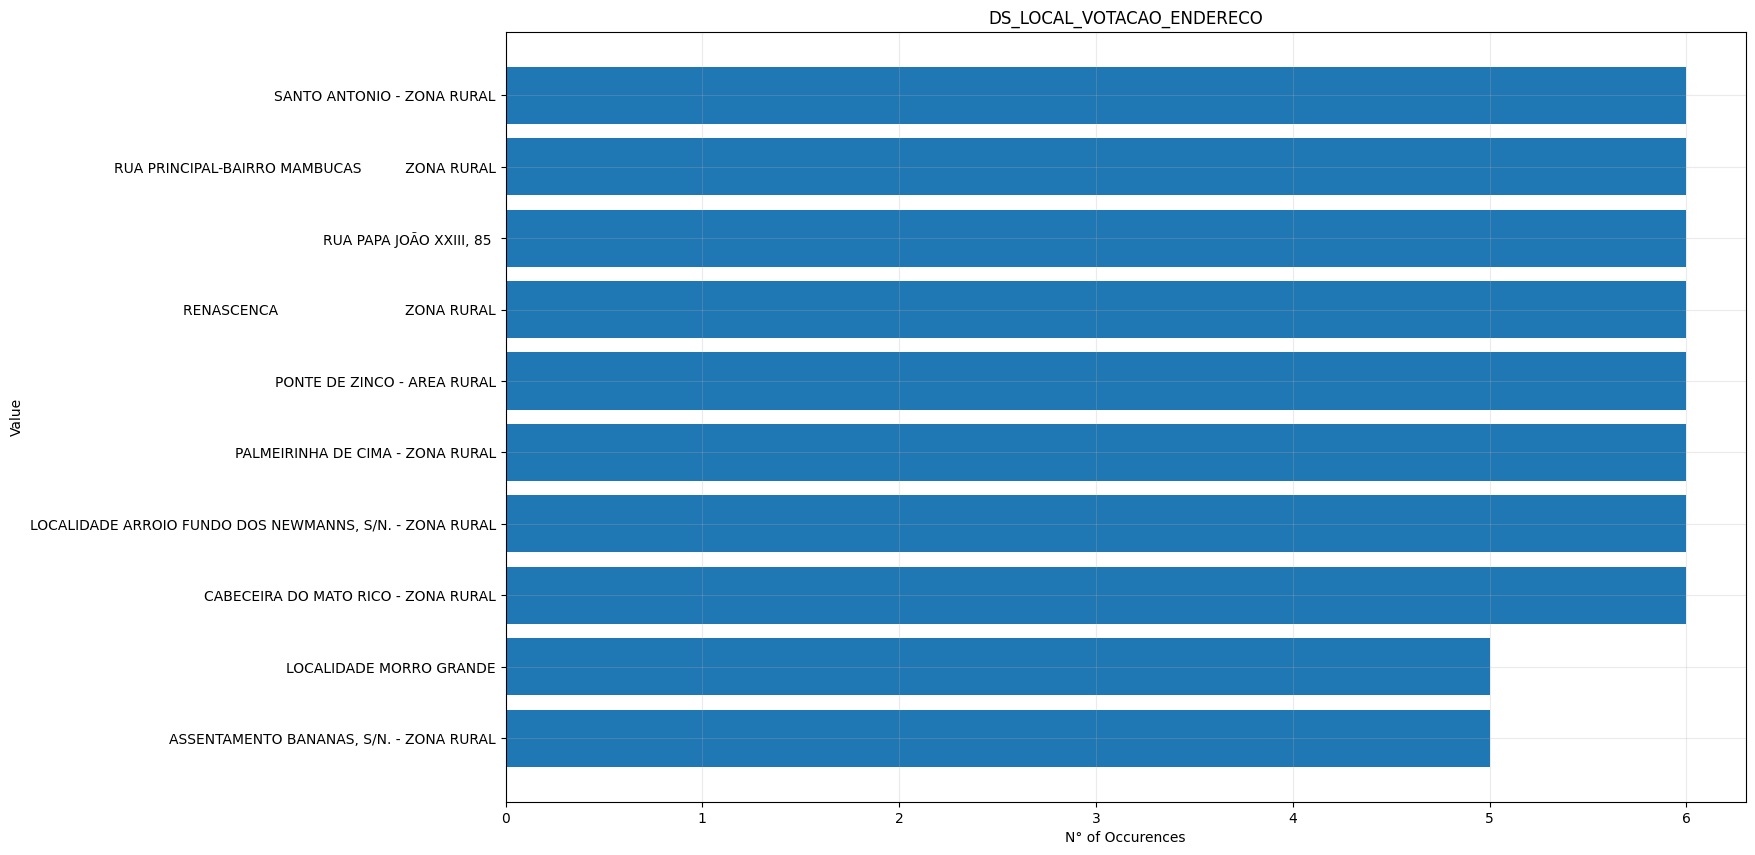

In [14]:
# Plots the top values of some columns
columns = [
    "NM_MUNICIPIO",
    "NM_VOTAVEL",
    "NM_LOCAL_VOTACAO",
    "DS_LOCAL_VOTACAO_ENDERECO",
]
for column in columns:
    values, counts = np.unique(votacao_secao_2022[column], return_counts=True)
    unique = dict(zip(values, counts))
    unique = dict(sorted(unique.items(), key=lambda item: item[1]))

    # Plotting the bar graph
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 10)

    ax.barh(list(unique.keys())[:10], list(unique.values())[:10])

    ax.grid(alpha=0.25)
    ax.set_title(column)
    ax.set_xlabel("N° of Occurences")
    ax.set_ylabel("Value")

    plt.show()
    plt.close()

In [15]:
# Checks the distribution of the numeric columns
votacao_secao_2022.describe()

,CD_MUNICIPIO,NR_ZONA,NR_SECAO,NR_VOTAVEL,QT_VOTOS,SQ_CANDIDATO,NR_LOCAL_VOTACAO
count,1.332398e+06,1.332398e+06,1.332398e+06,1.332398e+06,1.332398e+06,1.332398e+06,1.332398e+06
mean,4.111720e+06,9.617956e+01,2.246731e+02,3.204494e+04,4.276811e+00,1.600016e+11,1.327186e+03
std,7.463394e+03,6.657707e+01,1.851517e+02,2.221063e+04,1.021150e+01,4.376920e+04,3.209884e+02
min,4.100103e+06,1.000000e+00,1.000000e+00,1.000000e+04,1.000000e+00,1.600016e+11,1.015000e+03
25%,4.106902e+06,3.600000e+01,6.800000e+01,1.312300e+04,1.000000e+00,1.600016e+11,1.066000e+03
50%,4.108304e+06,8.900000e+01,1.790000e+02,2.222200e+04,1.000000e+00,1.600016e+11,1.210000e+03
75%,4.117305e+06,1.600000e+02,3.430000e+02,4.519000e+04,3.000000e+00,1.600017e+11,1.490000e+03
max,4.128807e+06,2.060000e+02,8.350000e+02,9.099900e+04,2.570000e+02,1.600017e+11,2.445000e+03


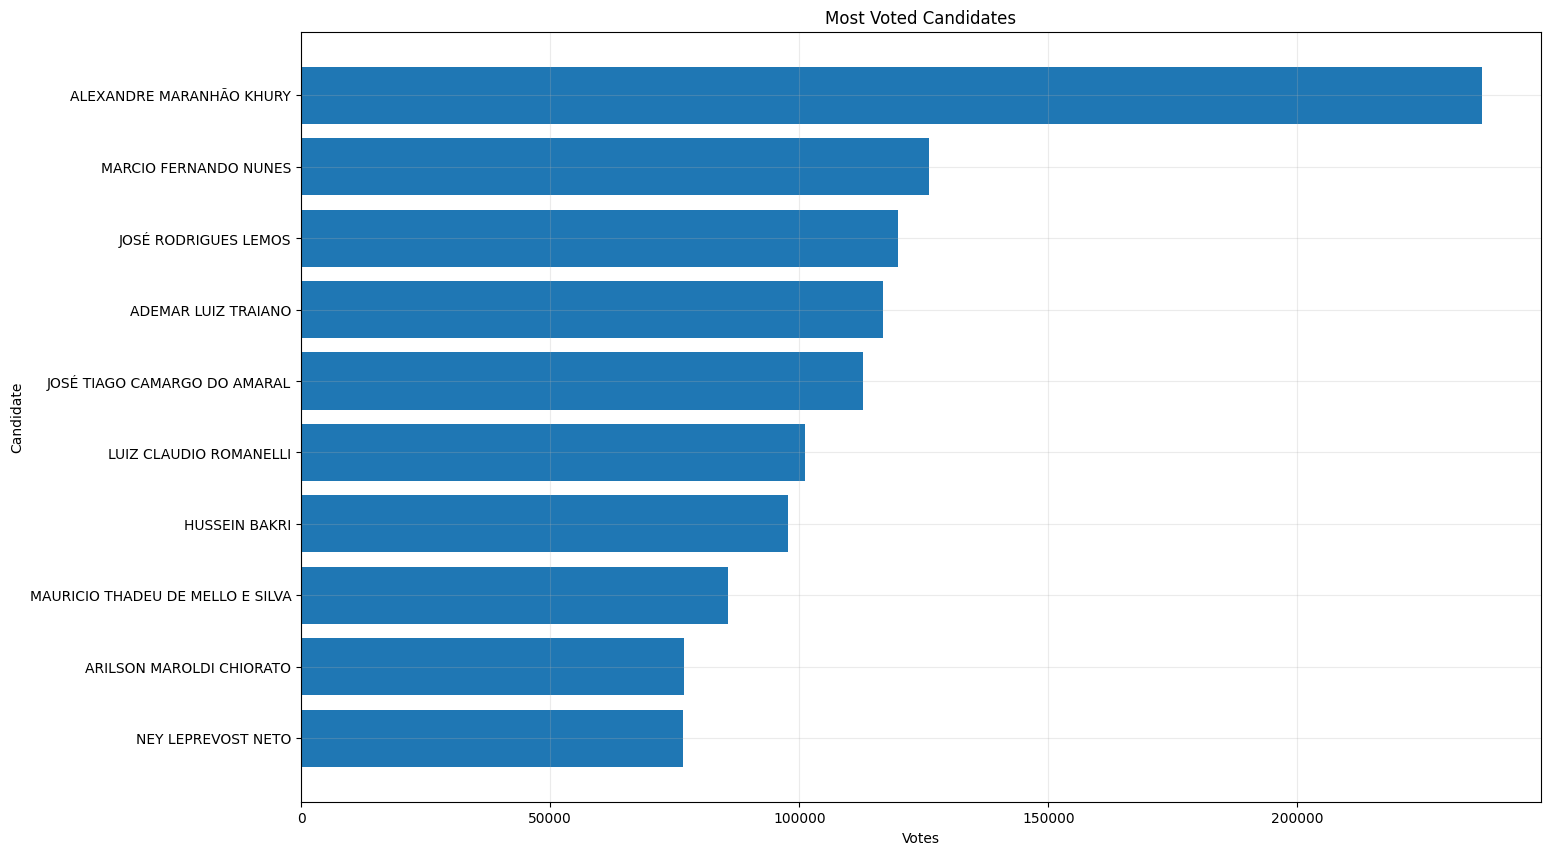

In [16]:
# Shows most voted candidates
most_voted = (
    votacao_secao_2022[["SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
    .groupby(["SQ_CANDIDATO", "NM_VOTAVEL"], as_index=False)
    .sum()
    .sort_values("QT_VOTOS", ascending=True)
)

# Plotting the bar graph
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

ax.barh(most_voted["NM_VOTAVEL"][-10:], most_voted["QT_VOTOS"][-10:])

ax.grid(alpha=0.25)
ax.set_title("Most Voted Candidates")
ax.set_xlabel("Votes")
ax.set_ylabel("Candidate")

plt.show()
plt.close()

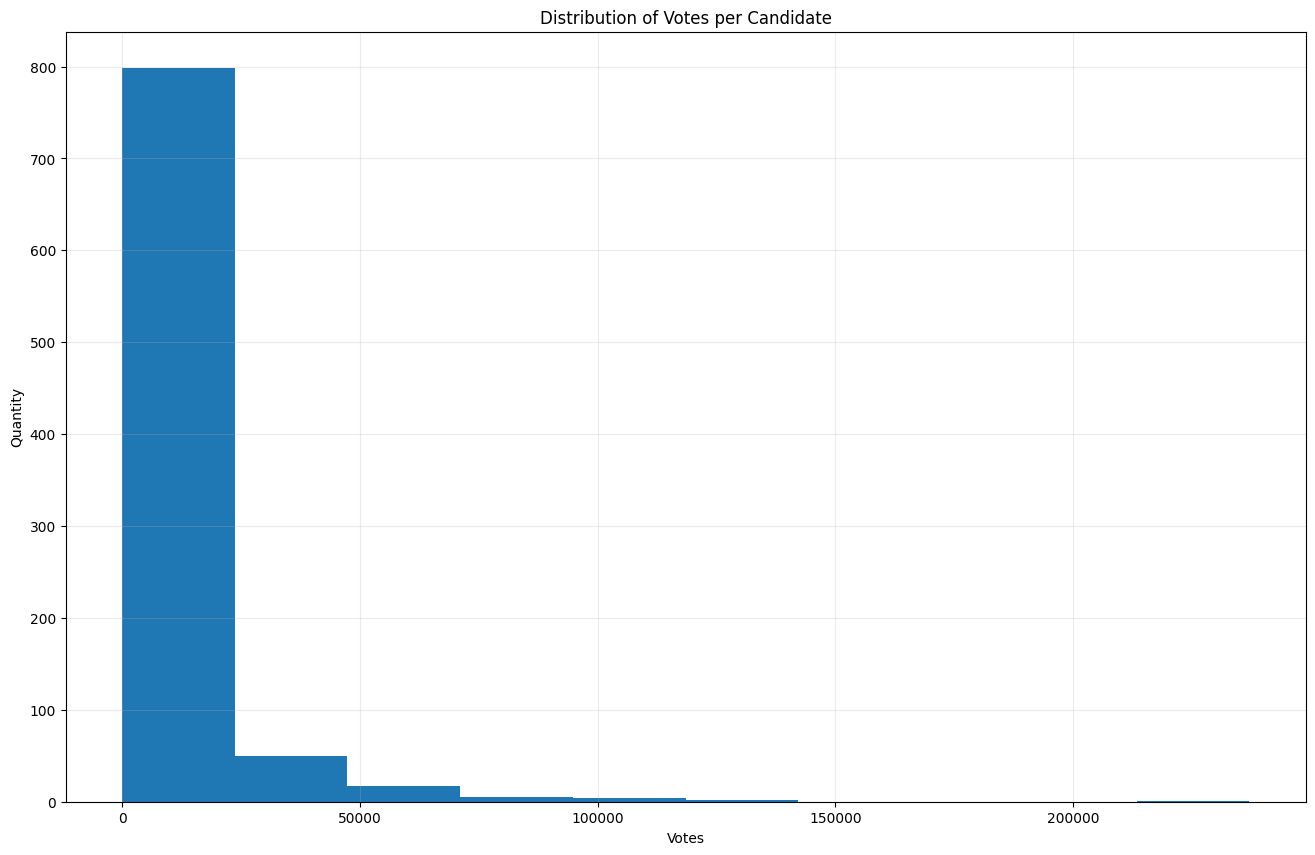

In [17]:
# Plotting the bar graph
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

ax.hist(most_voted["QT_VOTOS"])

ax.grid(alpha=0.25)
ax.set_title("Distribution of Votes per Candidate")
ax.set_xlabel("Votes")
ax.set_ylabel("Quantity")

plt.show()
plt.close()

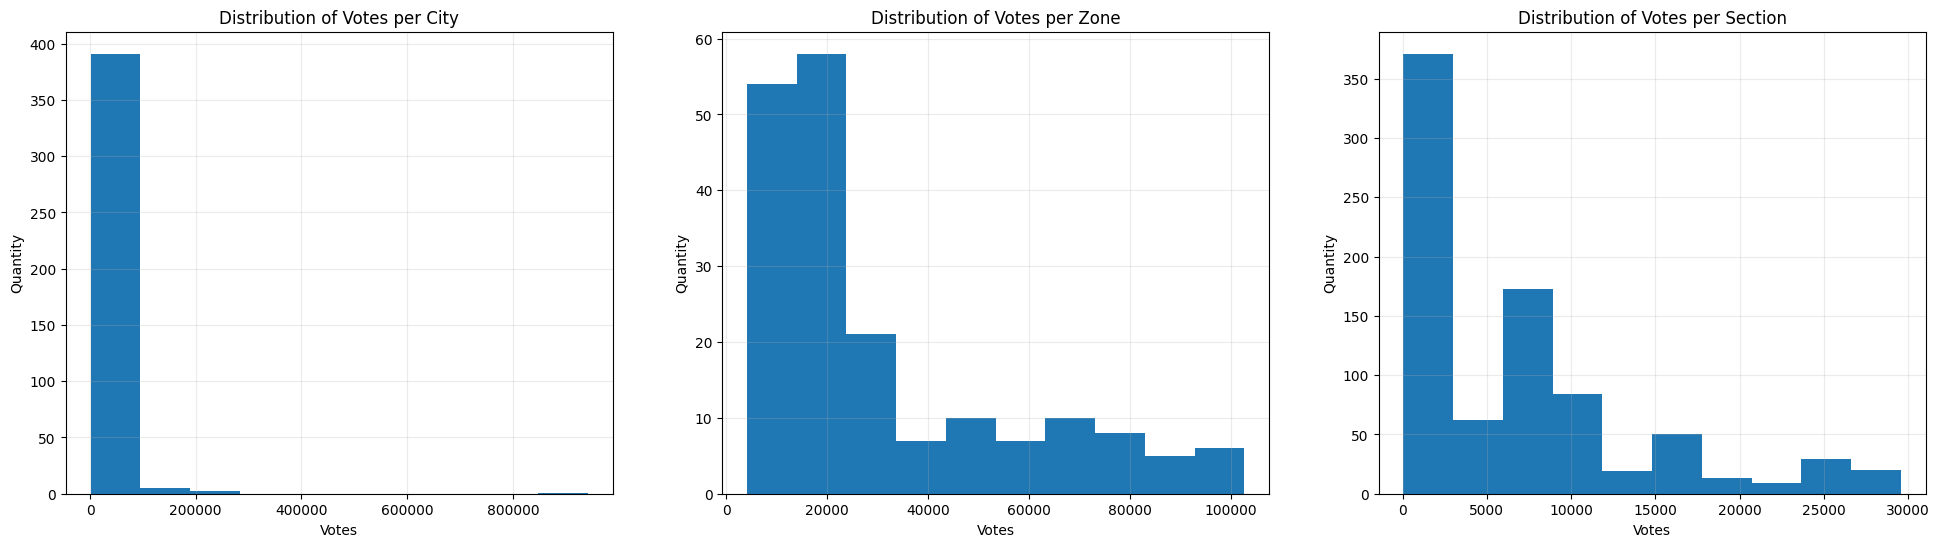

In [18]:
# Shows the distribution of votes per city/zone/section
votes_per_city = (
    votacao_secao_2022[["CD_MUNICIPIO", "QT_VOTOS"]]
    .groupby("CD_MUNICIPIO", as_index=False)
    .sum()
    .sort_values("QT_VOTOS", ascending=True)
)
votes_per_zone = (
    votacao_secao_2022[["NR_ZONA", "QT_VOTOS"]]
    .groupby("NR_ZONA", as_index=False)
    .sum()
    .sort_values("QT_VOTOS", ascending=True)
)
votes_per_section = (
    votacao_secao_2022[["NR_SECAO", "QT_VOTOS"]]
    .groupby("NR_SECAO", as_index=False)
    .sum()
    .sort_values("QT_VOTOS", ascending=True)
)

# Plotting the bar graph
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(24, 6)

ax[0].hist(votes_per_city["QT_VOTOS"])
ax[0].grid(alpha=0.25)
ax[0].set_title("Distribution of Votes per City")
ax[0].set_xlabel("Votes")
ax[0].set_ylabel("Quantity")

ax[1].hist(votes_per_zone["QT_VOTOS"])
ax[1].grid(alpha=0.25)
ax[1].set_title("Distribution of Votes per Zone")
ax[1].set_xlabel("Votes")
ax[1].set_ylabel("Quantity")

ax[2].hist(votes_per_section["QT_VOTOS"])
ax[2].grid(alpha=0.25)
ax[2].set_title("Distribution of Votes per Section")
ax[2].set_xlabel("Votes")
ax[2].set_ylabel("Quantity")

plt.show()
plt.close()

### **Census Data**

#### Reading and Initial Filtering/Cleaning of the Data

In [19]:
# Reads the data
censo_2022 = pd.read_csv(
    "./data/br_ibge_censo_2022_municipio.csv", sep=",", encoding="utf-8"
)
censo_2022.shape

(5570, 13)

In [20]:
censo_2022.columns

Index(['id_municipio', 'sigla_uf', 'domicilios', 'populacao', 'area',
       'taxa_alfabetizacao', 'idade_mediana', 'razao_sexo',
       'indice_envelhecimento', 'populacao_indigena',
       'populacao_indigena_terra_indigena', 'populacao_quilombola',
       'populacao_quilombola_territorio_quilombola'],
      dtype='object')

In [21]:
# Filters only the desired data

## sigla_uf must be PR
censo_2022 = censo_2022[censo_2022["sigla_uf"] == "PR"]

## Only these columns are of interest
columns = [
    "id_municipio",
    "domicilios",
    "populacao",
    "area",
    "taxa_alfabetizacao",
    "idade_mediana",
    "razao_sexo",
    "indice_envelhecimento",
]
censo_2022 = censo_2022[columns]

censo_2022.shape

(399, 8)

In [22]:
# Checks if there are any missing values
censo_2022[censo_2022.isna().any(axis=1)]

,id_municipio,domicilios,populacao,area,taxa_alfabetizacao,idade_mediana,razao_sexo,indice_envelhecimento


In [23]:
# Saving the processed data
censo_2022.to_csv("./processed_data/censo_mun.csv", index=False, sep=";")

In [24]:
censo_2022.dtypes

id_municipio               int64
domicilios                 int64
populacao                  int64
area                       int64
taxa_alfabetizacao       float64
idade_mediana              int64
razao_sexo               float64
indice_envelhecimento    float64
dtype: object

#### Exploratory Analysis

In [25]:
# Aggregation metrics for numerical values
num_columns = [
    "domicilios",
    "populacao",
    "area",
    "taxa_alfabetizacao",
    "idade_mediana",
    "razao_sexo",
    "indice_envelhecimento",
]
censo_2022[num_columns].describe()

,domicilios,populacao,area,taxa_alfabetizacao,idade_mediana,razao_sexo,indice_envelhecimento
count,399.000000,3.990000e+02,399.000000,399.000000,399.000000,399.000000,399.000000
mean,10549.954887,2.854817e+04,499.481203,0.924289,36.814536,99.014812,67.582105
std,39215.416443,1.023118e+05,450.806953,0.030032,2.733689,4.027726,17.934390
min,480.000000,1.323000e+03,61.000000,0.833130,29.000000,89.360000,22.110000
25%,1863.500000,4.913500e+03,214.500000,0.904465,35.000000,96.080000,54.425000
50%,3485.000000,9.660000e+03,353.000000,0.926890,37.000000,98.600000,65.980000
75%,6771.500000,1.852000e+04,614.500000,0.946190,39.000000,101.310000,79.270000
max,685874.000000,1.766225e+06,3168.000000,0.984720,44.000000,114.500000,123.630000


### **Census Sector Data**

In [26]:
# Reads the data
censo_sector_2022 = pd.read_csv(
    "./data/br_ibge_censo_2022_setor.csv", sep=",", encoding="utf-8"
)
censo_sector_2022.shape

(23777, 12)

In [27]:
censo_sector_2022.columns

Index(['id_uf', 'id_municipio', 'id_setor_censitario', 'area', 'geometria',
       'pessoas', 'domicilios', 'domicilios_particulares',
       'domicilios_coletivos', 'domicilios_particulares_ocupados',
       'media_moradores_domicilios', 'porcentagem_domicilios_imputados'],
      dtype='object')

In [28]:
# Filters only the desired data

## Only these columns are of interest
columns = [
    "id_municipio",
    "id_setor_censitario",
    "pessoas",
    "domicilios",
    "media_moradores_domicilios",
    "area",
    "geometria",
]
censo_sector_2022 = censo_sector_2022[columns]

censo_sector_2022.shape

(23777, 7)

In [29]:
# Checks if there are any missing values
censo_sector_2022[censo_sector_2022.isna().any(axis=1)]

,id_municipio,id_setor_censitario,pessoas,domicilios,media_moradores_domicilios,area,geometria


In [30]:
# Saving the processed data
censo_sector_2022.to_csv(
    "./processed_data/censo_sec.csv", index=False, sep=";"
)

In [31]:
censo_sector_2022.dtypes

id_municipio                    int64
id_setor_censitario             int64
pessoas                         int64
domicilios                      int64
media_moradores_domicilios    float64
area                          float64
geometria                      object
dtype: object

### **Voting Places Data**

In [32]:
# Reads the data
voting_places = pd.read_csv(
    "./data/geometrias_votacao_2022.csv", sep=",", encoding="utf-8"
)

In [33]:
# Filters only the desired data

## Only these columns are of interest
columns = ["id_municipio", "zona", "secao", "melhor_urbano"]
voting_places = voting_places[columns]

In [34]:
# Checks if there are any missing values
voting_places[voting_places.isna().any(axis=1)]

,id_municipio,zona,secao,melhor_urbano
333,4115705,194,144,NaN
359,4103040,38,285,NaN
397,4114609,121,128,NaN
399,4106902,177,781,NaN
421,4119608,38,115,NaN
464,4106902,177,787,NaN


In [35]:
# Drops missing values
voting_places = voting_places.dropna()

In [36]:
voting_places.shape

(487, 4)

In [37]:
votacao_secao_2022[["NR_ZONA", "NR_SECAO"]].drop_duplicates()

,NR_ZONA,NR_SECAO
0,44,396
1,124,46
2,87,41
3,145,329
4,141,177
...,...,...
1647182,83,23
1693597,69,204
1754805,16,80
1992707,28,433


In [38]:
# Saving the processed data
voting_places.to_csv(
    "./processed_data/mun_zone_section_location.csv", index=False, sep=";"
)

### **RAIS**

In [39]:
# Reads the data
rais = pd.read_csv("./data/rais.csv", sep=",", encoding="utf-8")

In [40]:
# Checks if there are any missing values
rais[rais.isna().any(axis=1)]

,ano,sigla_uf,id_municipio,tipo_vinculo,vinculo_ativo_3112,tipo_admissao,tempo_emprego,quantidade_horas_contratadas,valor_remuneracao_media_sm,valor_remuneracao_dezembro_sm,cbo_2002,cnae_2,cnae_2_subclasse,idade,grau_instrucao_apos_2005,nacionalidade,sexo,raca_cor,indicador_portador_deficiencia,tipo_deficiencia


In [41]:
# Saving the processed data
rais.to_csv("./processed_data/rais.csv", index=False, sep=";")

In [42]:
rais.dtypes

ano                                 int64
sigla_uf                           object
id_municipio                        int64
tipo_vinculo                        int64
vinculo_ativo_3112                  int64
tipo_admissao                       int64
tempo_emprego                     float64
quantidade_horas_contratadas        int64
valor_remuneracao_media_sm        float64
valor_remuneracao_dezembro_sm     float64
cbo_2002                            int64
cnae_2                              int64
cnae_2_subclasse                    int64
idade                               int64
grau_instrucao_apos_2005            int64
nacionalidade                       int64
sexo                                int64
raca_cor                            int64
indicador_portador_deficiencia      int64
tipo_deficiencia                    int64
dtype: object

### **Extra**

In [43]:
# Reads the data
extra = pd.read_csv("./data/conectividade.csv", sep=",", encoding="utf-8")

In [44]:
# Checks if there are any missing values
extra[extra.isna().any(axis=1)]

,ano,sigla_uf,id_municipio,ibc,cobertura_pop_4g5g,fibra,densidade_smp,hhi_smp,densidade_scm,hhi_scm,adensamento_estacoes


In [45]:
# Saving the processed data
extra.to_csv("./processed_data/extra.csv", index=False, sep=";")

In [46]:
extra.dtypes

ano                       int64
sigla_uf                 object
id_municipio              int64
ibc                     float64
cobertura_pop_4g5g      float64
fibra                     int64
densidade_smp           float64
hhi_smp                   int64
densidade_scm           float64
hhi_scm                   int64
adensamento_estacoes    float64
dtype: object

### **Building the Database**

#### Opening Connection

In [ ]:
# Psycopg2
import psycopg2

conn = psycopg2.connect(
    f"dbname={db} user={user} password={password} host={host} port={port}"
)
cur = conn.cursor()

In [ ]:
# SQL Alchemy
from sqlalchemy import create_engine

engine = create_engine(f"postgresql://{user}:{password}@{host}:{port}/{db}")

#### resultados_secao

In [ ]:
# Executes changes
cur.execute(
    """
    CREATE TABLE resultados_secao (
        cd_municipio int,
        nm_municipio varchar,
        nr_zona int,
        nr_secao int,
        nr_votavel int,
        nm_votavel varchar,
        qt_votos int,
        sq_candidato bigint,
        nr_local_votacao int,
        nm_local_votacao varchar,
        ds_local_votacao_endereco varchar
    );
    """
)

# Applies changes
conn.commit()

In [ ]:
# Executes changes
f = open("./processed_data/resultados_secao.csv", "r")
cur.copy_from(f, table="resultados_secao", sep=";")
f.close()

# Applies changes
conn.commit()

#### censo_mun

In [ ]:
# Executes changes
cur.execute(
    """
    CREATE TABLE censo_mun (
        id_municipio int,
        domicilios int,
        populacao int,
        area int,
        taxa_alfabetizacao float,
        idade_mediana int,
        razao_sexo float,
        indice_envelhecimento float
    );
    """
)

# Applies changes
conn.commit()

In [ ]:
# Executes changes
f = open("./processed_data/censo_mun.csv", "r")
cur.copy_from(f, table="censo_mun", sep=";")
f.close()

# Applies changes
conn.commit()

#### censo_sec

In [ ]:
# Executes changes
cur.execute(
    """
    CREATE TABLE censo_sec (
        id_municipio int,
        id_setor_censitario bigint,
        pessoas int,
        domicilios int,
        media_moradores_domicilios float,
        area float,
        geom geography
    );
    """
)

# Applies changes
conn.commit()

In [ ]:
# Executes changes
f = open("./processed_data/censo_sec.csv", "r")
cur.copy_from(f, table="censo_sec", sep=";")
f.close()

# Applies changes
conn.commit()

#### mun_zona_sec_local

In [ ]:
# Executes changes
cur.execute(
    """
    CREATE TABLE mun_zona_sec_local (
        id_municipio int,
        zona int,
        secao int,
        geom geography
    );
    """
)

# Applies changes
conn.commit()

In [ ]:
# Executes changes
f = open("./processed_data/mun_zone_section_location.csv", "r")
cur.copy_from(f, table="mun_zona_sec_local", sep=";")
f.close()

# Applies changes
conn.commit()

#### rais

In [ ]:
# Executes changes
cur.execute(
    """
    CREATE TABLE rais (
        ano int,
        sigla_uf varchar,
        id_municipio int,
        tipo_vinculo int,
        vinculo_ativo_3112 int,
        tipo_admissao int,
        tempo_emprego float,
        quantidade_horas_contratadas int,
        valor_remuneracao_media_sm float,
        valor_remuneracao_dezembro_sm float,
        cbo_2002 int,
        cnae_2 int,
        cnae_2_subclasse int,
        idade int,
        grau_instrucao_apos_2005 int,
        nacionalidade int,
        sexo int,
        raca_cor int,
        indicador_portador_deficiencia int,
        tipo_deficiencia int
    );
    """
)

# Applies changes
conn.commit()

In [ ]:
# Executes changes
f = open("./processed_data/rais.csv", "r")
cur.copy_from(f, table="rais", sep=";")
f.close()

# Applies changes
conn.commit()

#### extra

In [ ]:
# Executes changes
cur.execute(
    """
    CREATE TABLE extra (
        ano int,
        sigla_uf varchar,
        id_municipio int,
        ibc float,
        cobertura_pop_4g5g float,
        fibra int,
        densidade_smp float,
        hhi_smp int,
        densidade_scm float,
        hhi_scm int,
        adensamento_estacoes float
    );
    """
)

# Applies changes
conn.commit()

In [ ]:
# Executes changes
f = open("./processed_data/extra.csv", "r")
cur.copy_from(f, table="extra", sep=";")
f.close()

# Applies changes
conn.commit()

#### geometries

In [ ]:
gdf = gpd.read_file("./data/PR_Municipios_2024.shp")
gdf.to_postgis("geo_mun", engine, if_exists="replace", index=False)

gdf = gpd.read_file("./data/PR_RG_Imediatas_2024.shp")
gdf.to_postgis("geo_reg_ime", engine, if_exists="replace", index=False)

gdf = gpd.read_file("./data/PR_RG_Intermediarias_2024.shp")
gdf.to_postgis("geo_reg_int", engine, if_exists="replace", index=False)

#### Closing Connection

In [ ]:
# Finilizes the connection
cur.close()
conn.close()
engine.dispose()

### **Analysis**

#### Spatial Correlation by Municipality

In [ ]:
votes = pd.read_csv("./processed_data/resultados_secao.csv", sep=";")
votes_per_candidate_per_mun = (
    votes[["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
    .groupby(
        by=["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL"],
        as_index=False,
    )
    .sum()
)

In [ ]:
votes_per_candidate = (
    votes[["SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
    .groupby(["SQ_CANDIDATO", "NM_VOTAVEL"], as_index=False)
    .sum()
    .sort_values("QT_VOTOS", ascending=False)
)
candidate_numbers_sorted_by_votes = list(votes_per_candidate["SQ_CANDIDATO"])

In [ ]:
votes_per_candidate[:20]

In [ ]:
# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes_per_candidate_per_mun["CD_MUNICIPIO"].unique():
    votos_mun = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["CD_MUNICIPIO"] == municipio
    ]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes_per_candidate_per_mun["QT_VOTOS"] = norm_qt_votos

In [ ]:
geo_mun = gpd.read_file("./data/PR_Municipios_2024.shp")
geo_mun = geo_mun.rename({"CD_MUN": "CD_MUNICIPIO"}, axis=1)
geo_mun["CD_MUNICIPIO"] = geo_mun["CD_MUNICIPIO"].astype("int64")
geometry = geo_mun.set_index("CD_MUNICIPIO")[["geometry"]]
geometry = geometry.sort_index()

In [ ]:
weights = Queen.from_dataframe(geometry, use_index=True)
weights.transform = "r"

In [ ]:
best_candidates_statistics = pd.DataFrame(
    columns=["Candidate", "Moran-I", "P-value", "Z-score"]
)
for n_candidate in candidate_numbers_sorted_by_votes[:5]:
    # Organizes the data
    data = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["SQ_CANDIDATO"] == n_candidate
    ].set_index("CD_MUNICIPIO")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_MUNICIPIO", how="outer")[
        ["QT_VOTOS"]
    ].fillna(0)
    data = data.sort_index()

    candidate_name = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["SQ_CANDIDATO"] == n_candidate
    ]["NM_VOTAVEL"].unique()[0]

    moran = Moran(data, weights)
    best_candidates_statistics.loc[-1] = [
        candidate_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    best_candidates_statistics.index = best_candidates_statistics.index + 1
best_candidates_statistics = best_candidates_statistics.reset_index(drop=True)
display(best_candidates_statistics)

In [ ]:
worst_candidates_statistics = pd.DataFrame(
    columns=["Candidate", "Moran-I", "P-value", "Z-score"]
)
for n_candidate in candidate_numbers_sorted_by_votes[-5:]:
    # Organizes the data
    data = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["SQ_CANDIDATO"] == n_candidate
    ].set_index("CD_MUNICIPIO")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_MUNICIPIO", how="outer")[
        ["QT_VOTOS"]
    ].fillna(0)
    data = data.sort_index()

    candidate_name = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["SQ_CANDIDATO"] == n_candidate
    ]["NM_VOTAVEL"].unique()[0]

    moran = Moran(data, weights)
    worst_candidates_statistics.loc[-1] = [
        candidate_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    worst_candidates_statistics.index = worst_candidates_statistics.index + 1
worst_candidates_statistics = worst_candidates_statistics.reset_index(drop=True)
display(worst_candidates_statistics)

In [ ]:
best_candidates_statistics = pd.DataFrame(
    columns=["Candidate", "Moran-I", "P-value", "Z-score"]
)
for n_candidate in candidate_numbers_sorted_by_votes[:54]:
    # Organizes the data
    data = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["SQ_CANDIDATO"] == n_candidate
    ].set_index("CD_MUNICIPIO")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_MUNICIPIO", how="outer")[
        ["QT_VOTOS"]
    ].fillna(0)
    data = data.sort_index()

    candidate_name = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["SQ_CANDIDATO"] == n_candidate
    ]["NM_VOTAVEL"].unique()[0]

    moran = Moran(data, weights)
    best_candidates_statistics.loc[-1] = [
        candidate_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    best_candidates_statistics.index = best_candidates_statistics.index + 1
best_candidates_statistics = best_candidates_statistics.reset_index(drop=True)
display(best_candidates_statistics)

In [ ]:
# Plotting the bar graph
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

ax.hist(best_candidates_statistics["Moran-I"], bins=20)

ax.grid(alpha=0.25)
ax.set_title("Distribution of Moran's I - Votes per Candidate per Municipality")
ax.set_xlabel("Moran-I")
ax.set_ylabel("Count")

plt.show()
plt.close()

#### Spatial Correlation by Immediate Region

In [ ]:
geo_mun = gpd.read_file("./data/PR_Municipios_2024.shp")
geo_mun = geo_mun.rename({"CD_MUN": "CD_MUNICIPIO"}, axis=1)
geo_mun["CD_MUNICIPIO"] = geo_mun["CD_MUNICIPIO"].astype("int64")
geo_mun["CD_RGI"] = geo_mun["CD_RGI"].astype("int64")
geo_ime = gpd.read_file("./data/PR_RG_Imediatas_2024.shp")
geo_ime["CD_RGI"] = geo_ime["CD_RGI"].astype("int64")
geometry = geo_ime.set_index("CD_RGI")[["geometry"]]
geometry = geometry.sort_index()

In [ ]:
mun_ime_map = pd.merge(
    geo_mun[["CD_MUNICIPIO", "CD_RGI"]], geo_ime[["CD_RGI", "NM_RGI"]], on="CD_RGI"
)

In [ ]:
votes_per_candidate_per_ime = pd.merge(
    mun_ime_map, votes_per_candidate_per_mun, on="CD_MUNICIPIO"
)[["CD_RGI", "NM_RGI", "SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
votes_per_candidate_per_ime = votes_per_candidate_per_ime.groupby(
    by=["CD_RGI", "NM_RGI", "SQ_CANDIDATO", "NM_VOTAVEL"], as_index=False
).sum()

In [ ]:
# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes_per_candidate_per_ime["CD_RGI"].unique():
    votos_mun = votes_per_candidate_per_ime[
        votes_per_candidate_per_ime["CD_RGI"] == municipio
    ]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes_per_candidate_per_ime["QT_VOTOS"] = norm_qt_votos

In [ ]:
weights = Queen.from_dataframe(geometry, use_index=True)
weights.transform = "r"

In [ ]:
best_candidates_statistics = pd.DataFrame(
    columns=["Candidate", "Moran-I", "P-value", "Z-score"]
)
for n_candidate in candidate_numbers_sorted_by_votes[:54]:
    # Organizes the data
    data = votes_per_candidate_per_ime[
        votes_per_candidate_per_ime["SQ_CANDIDATO"] == n_candidate
    ].set_index("CD_RGI")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_RGI", how="outer")[["QT_VOTOS"]].fillna(0)
    data = data.sort_index()

    candidate_name = votes_per_candidate_per_ime[
        votes_per_candidate_per_ime["SQ_CANDIDATO"] == n_candidate
    ]["NM_VOTAVEL"].unique()[0]

    moran = Moran(data, weights)
    best_candidates_statistics.loc[-1] = [
        candidate_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    best_candidates_statistics.index = best_candidates_statistics.index + 1
best_candidates_statistics = best_candidates_statistics.reset_index(drop=True)
display(best_candidates_statistics)

In [ ]:
worst_candidates_statistics = pd.DataFrame(
    columns=["Candidate", "Moran-I", "P-value", "Z-score"]
)
for n_candidate in candidate_numbers_sorted_by_votes[-5:]:
    # Organizes the data
    data = votes_per_candidate_per_ime[
        votes_per_candidate_per_ime["SQ_CANDIDATO"] == n_candidate
    ].set_index("CD_RGI")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_RGI", how="outer")[["QT_VOTOS"]].fillna(0)
    data = data.sort_index()

    candidate_name = votes_per_candidate_per_ime[
        votes_per_candidate_per_ime["SQ_CANDIDATO"] == n_candidate
    ]["NM_VOTAVEL"].unique()[0]

    moran = Moran(data, weights)
    worst_candidates_statistics.loc[-1] = [
        candidate_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    worst_candidates_statistics.index = worst_candidates_statistics.index + 1
worst_candidates_statistics = worst_candidates_statistics.reset_index(drop=True)
display(worst_candidates_statistics)

In [ ]:
# Plotting the bar graph
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

ax.hist(best_candidates_statistics["Moran-I"], bins=20)

ax.grid(alpha=0.25)
ax.set_title("Distribution of Moran's I - Votes per Candidate per Immediate Region")
ax.set_xlabel("Moran-I")
ax.set_ylabel("Count")

plt.show()
plt.close()

#### Spatial Correlation by Intermediate Region

In [ ]:
geo_ime = gpd.read_file("./data/PR_RG_Imediatas_2024.shp")
geo_ime["CD_RGI"] = geo_ime["CD_RGI"].astype("int64")
geo_ime["CD_RGINT"] = geo_ime["CD_RGINT"].astype("int64")
geo_int = gpd.read_file("./data/PR_RG_Intermediarias_2024.shp")
geo_int["CD_RGINT"] = geo_int["CD_RGINT"].astype("int64")
geometry = geo_int.set_index("CD_RGINT")[["geometry"]]
geometry = geometry.sort_index()

In [ ]:
ime_int_map = pd.merge(
    geo_ime[["CD_RGI", "CD_RGINT"]], geo_int[["CD_RGINT", "NM_RGINT"]], on="CD_RGINT"
)

In [ ]:
votes_per_candidate_per_int = pd.merge(
    ime_int_map, votes_per_candidate_per_ime, on="CD_RGI"
)[["CD_RGINT", "NM_RGINT", "SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
votes_per_candidate_per_int = votes_per_candidate_per_int.groupby(
    by=["CD_RGINT", "NM_RGINT", "SQ_CANDIDATO", "NM_VOTAVEL"], as_index=False
).sum()

In [ ]:
# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes_per_candidate_per_int["CD_RGINT"].unique():
    votos_mun = votes_per_candidate_per_int[
        votes_per_candidate_per_int["CD_RGINT"] == municipio
    ]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes_per_candidate_per_int["QT_VOTOS"] = norm_qt_votos

In [ ]:
weights = Queen.from_dataframe(geometry, use_index=True)
weights.transform = "r"

In [ ]:
best_candidates_statistics = pd.DataFrame(
    columns=["Candidate", "Moran-I", "P-value", "Z-score"]
)
for n_candidate in candidate_numbers_sorted_by_votes[:54]:
    # Organizes the data
    data = votes_per_candidate_per_int[
        votes_per_candidate_per_int["SQ_CANDIDATO"] == n_candidate
    ].set_index("CD_RGINT")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_RGINT", how="outer")[["QT_VOTOS"]].fillna(0)
    data = data.sort_index()

    candidate_name = votes_per_candidate_per_int[
        votes_per_candidate_per_int["SQ_CANDIDATO"] == n_candidate
    ]["NM_VOTAVEL"].unique()[0]

    moran = Moran(data, weights)
    best_candidates_statistics.loc[-1] = [
        candidate_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    best_candidates_statistics.index = best_candidates_statistics.index + 1
best_candidates_statistics = best_candidates_statistics.reset_index(drop=True)
display(best_candidates_statistics)

In [ ]:
worst_candidates_statistics = pd.DataFrame(
    columns=["Candidate", "Moran-I", "P-value", "Z-score"]
)
for n_candidate in candidate_numbers_sorted_by_votes[-5:]:
    # Organizes the data
    data = votes_per_candidate_per_int[
        votes_per_candidate_per_int["SQ_CANDIDATO"] == n_candidate
    ].set_index("CD_RGINT")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_RGINT", how="outer")[["QT_VOTOS"]].fillna(0)
    data = data.sort_index()

    candidate_name = votes_per_candidate_per_int[
        votes_per_candidate_per_int["SQ_CANDIDATO"] == n_candidate
    ]["NM_VOTAVEL"].unique()[0]

    moran = Moran(data, weights)
    worst_candidates_statistics.loc[-1] = [
        candidate_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    worst_candidates_statistics.index = worst_candidates_statistics.index + 1
worst_candidates_statistics = worst_candidates_statistics.reset_index(drop=True)
display(worst_candidates_statistics)

In [ ]:
# Plotting the bar graph
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

ax.hist(best_candidates_statistics["Moran-I"], bins=20)

ax.grid(alpha=0.25)
ax.set_title("Distribution of Moran's I - Votes per Candidate per Intermediate Region")
ax.set_xlabel("Moran-I")
ax.set_ylabel("Count")

plt.show()
plt.close()

#### Spatial Correlation per Political Party by Municipality

In [ ]:
votes = pd.read_csv(
    "./data/votacao_partido_munzona_2022_PR.csv", sep=";", encoding="latin-1"
)
votes["QT_VOTOS"] = (
    votes["QT_VOTOS_NOMINAIS_VALIDOS"] + votes["QT_TOTAL_VOTOS_LEG_VALIDOS"]
)

with open("./data/mapa-cod-municipio.csv", mode="r") as infile:
    reader = csv.reader(infile)
    code_mapping = {int(rows[1]): int(rows[0]) for rows in reader}
votes["CD_MUNICIPIO"] = votes["CD_MUNICIPIO"].map(code_mapping)

votes_per_party_per_mun = (
    votes[["CD_MUNICIPIO", "NM_MUNICIPIO", "NR_PARTIDO", "NM_PARTIDO", "QT_VOTOS"]]
    .groupby(
        by=["CD_MUNICIPIO", "NM_MUNICIPIO", "NR_PARTIDO", "NM_PARTIDO"], as_index=False
    )
    .sum()
)

In [ ]:
votes_per_party = (
    votes[["NR_PARTIDO", "QT_VOTOS"]]
    .groupby(["NR_PARTIDO"], as_index=False)
    .sum()
    .sort_values("QT_VOTOS", ascending=False)
)
parties_sorted_by_votes = list(votes_per_party["NR_PARTIDO"])

In [ ]:
# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes_per_party_per_mun["CD_MUNICIPIO"].unique():
    votos_mun = votes_per_party_per_mun[
        votes_per_party_per_mun["CD_MUNICIPIO"] == municipio
    ]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes_per_party_per_mun["QT_VOTOS"] = norm_qt_votos

In [ ]:
geo_mun = gpd.read_file("./data/PR_Municipios_2024.shp")
geo_mun = geo_mun.rename({"CD_MUN": "CD_MUNICIPIO"}, axis=1)
geo_mun["CD_MUNICIPIO"] = geo_mun["CD_MUNICIPIO"].astype("int64")
geometry = geo_mun.set_index("CD_MUNICIPIO")[["geometry"]]
geometry = geometry.sort_index()

In [ ]:
weights = Queen.from_dataframe(geometry, use_index=True)
weights.transform = "r"

In [ ]:
best_parties_statistics = pd.DataFrame(
    columns=["Party", "Moran-I", "P-value", "Z-score"]
)
for n_party in parties_sorted_by_votes:
    # Organizes the data
    data = votes_per_party_per_mun[
        votes_per_party_per_mun["NR_PARTIDO"] == n_party
    ].set_index("CD_MUNICIPIO")[["QT_VOTOS"]]
    data = pd.merge(data, geometry, on="CD_MUNICIPIO", how="outer")[
        ["QT_VOTOS"]
    ].fillna(0)
    data = data.sort_index()

    party_name = votes_per_party_per_mun[
        votes_per_party_per_mun["NR_PARTIDO"] == n_party
    ]["NM_PARTIDO"].unique()[0]

    moran = Moran(data, weights)
    best_parties_statistics.loc[-1] = [
        party_name,
        moran.I,
        moran.p_sim,
        moran.z_sim,
    ]
    best_parties_statistics.index = best_parties_statistics.index + 1
best_parties_statistics = best_parties_statistics.reset_index(drop=True)
display(best_parties_statistics)

In [ ]:
# Plotting the bar graph
fig, ax = plt.subplots()
fig.set_size_inches(16, 10)

ax.hist(best_parties_statistics["Moran-I"])

ax.grid(alpha=0.25)
ax.set_title("Distribution of Moran's I - Votes per Political Party per Municipality")
ax.set_xlabel("Moran-I")
ax.set_ylabel("Count")

plt.show()
plt.close()

#### Normal Correlation

##### Alexandre Khury

In [ ]:
# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes_per_candidate_per_mun["CD_MUNICIPIO"].unique():
    votos_mun = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["CD_MUNICIPIO"] == municipio
    ]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes_per_candidate_per_mun["QT_VOTOS"] = norm_qt_votos

In [ ]:
votes = pd.read_csv("./processed_data/resultados_secao.csv", sep=";")
votes = (
    votes[["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
    .groupby(
        by=["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL"],
        as_index=False,
    )
    .sum()
)

# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes["CD_MUNICIPIO"].unique():
    votos_mun = votes[votes["CD_MUNICIPIO"] == municipio]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes["QT_VOTOS"] = norm_qt_votos

# Filters and rearranges the data
votes = votes[votes["SQ_CANDIDATO"] == 160001623100].rename(
    {"CD_MUNICIPIO": "id_municipio", "QT_VOTOS": "qt_votos"}, axis=1
)

# Gathers other data
censo = pd.read_csv("./processed_data/censo_mun.csv", sep=";")
censo = censo[["id_municipio", "taxa_alfabetizacao", "idade_mediana", "razao_sexo"]]

rais = pd.read_csv("./processed_data/rais.csv", sep=";")
rais = rais[["id_municipio", "valor_remuneracao_dezembro_sm"]]
rais = rais.groupby(by="id_municipio", as_index=False).mean()

extra = pd.read_csv("./processed_data/extra.csv", sep=";")
extra = extra[["id_municipio", "cobertura_pop_4g5g", "densidade_smp"]]

# Merges everything
columns = [
    "qt_votos",
    "cobertura_pop_4g5g",
    "densidade_smp",
    "valor_remuneracao_dezembro_sm",
    "taxa_alfabetizacao",
    "idade_mediana",
    "razao_sexo",
]
data = pd.merge(votes, censo, on="id_municipio", how="outer").fillna(0)
data = pd.merge(
    pd.merge(data, rais, on="id_municipio"),
    extra,
    on="id_municipio",
)[columns]

In [ ]:
# Plots the full pairplot
sns.set_theme()
grid = sns.pairplot(data)

In [ ]:
# Calculates correlations
correlations = data.corr()
correlations

In [ ]:
# Plots correlations
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(20, 15)
fig.suptitle("Correlação de Variáveis com Votos - Alexandre Khury", fontsize=16)

sns.regplot(
    data=data,
    x="taxa_alfabetizacao",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[0][0],
)
ax[0][0].set_title(
    f"Taxa de Alfabetização - Correlação: {correlations["qt_votos"]["taxa_alfabetizacao"]}"
)

sns.regplot(
    data=data,
    x="cobertura_pop_4g5g",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[0][1],
)
ax[0][1].set_title(
    f"Cobertura 4G/5G - Correlação: {correlations["qt_votos"]["cobertura_pop_4g5g"]}"
)

sns.regplot(
    data=data,
    x="razao_sexo",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[1][0],
)
ax[1][0].set_title(f"Razão Sexo - Correlação: {correlations["qt_votos"]["razao_sexo"]}")

sns.regplot(
    data=data,
    x="idade_mediana",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[1][1],
)
ax[1][1].set_title(
    f"Idade Mediana - Correlação: {correlations["qt_votos"]["idade_mediana"]}"
)

plt.show()
plt.close()

##### Lemos

In [ ]:
# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes_per_candidate_per_mun["CD_MUNICIPIO"].unique():
    votos_mun = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["CD_MUNICIPIO"] == municipio
    ]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes_per_candidate_per_mun["QT_VOTOS"] = norm_qt_votos

In [ ]:
votes = pd.read_csv("./processed_data/resultados_secao.csv", sep=";")
votes = (
    votes[["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
    .groupby(
        by=["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL"],
        as_index=False,
    )
    .sum()
)

# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes["CD_MUNICIPIO"].unique():
    votos_mun = votes[votes["CD_MUNICIPIO"] == municipio]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes["QT_VOTOS"] = norm_qt_votos

# Filters and rearranges the data
votes = votes[votes["SQ_CANDIDATO"] == 160001615032].rename(
    {"CD_MUNICIPIO": "id_municipio", "QT_VOTOS": "qt_votos"}, axis=1
)

# Gathers other data
censo = pd.read_csv("./processed_data/censo_mun.csv", sep=";")
censo = censo[["id_municipio", "taxa_alfabetizacao", "idade_mediana", "razao_sexo"]]

rais = pd.read_csv("./processed_data/rais.csv", sep=";")
rais = rais[["id_municipio", "valor_remuneracao_dezembro_sm"]]
rais = rais.groupby(by="id_municipio", as_index=False).mean()

extra = pd.read_csv("./processed_data/extra.csv", sep=";")
extra = extra[["id_municipio", "cobertura_pop_4g5g", "densidade_smp"]]

# Merges everything
columns = [
    "qt_votos",
    "cobertura_pop_4g5g",
    "densidade_smp",
    "valor_remuneracao_dezembro_sm",
    "taxa_alfabetizacao",
    "idade_mediana",
    "razao_sexo",
]
data = pd.merge(votes, censo, on="id_municipio", how="outer").fillna(0)
data = pd.merge(
    pd.merge(data, rais, on="id_municipio"),
    extra,
    on="id_municipio",
)[columns]

In [ ]:
# Plots the full pairplot
sns.set_theme()
grid = sns.pairplot(data)

In [ ]:
# Calculates correlations
correlations = data.corr()
correlations

In [ ]:
# Plots correlations
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(20, 15)
fig.suptitle("Correlação de Variáveis com Votos - José Lemos", fontsize=16)

sns.regplot(
    data=data,
    x="taxa_alfabetizacao",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[0][0],
)
ax[0][0].set_title(
    f"Taxa de Alfabetização - Correlação: {correlations["qt_votos"]["taxa_alfabetizacao"]}"
)

sns.regplot(
    data=data,
    x="cobertura_pop_4g5g",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[0][1],
)
ax[0][1].set_title(
    f"Cobertura 4G/5G - Correlação: {correlations["qt_votos"]["cobertura_pop_4g5g"]}"
)

sns.regplot(
    data=data,
    x="razao_sexo",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[1][0],
)
ax[1][0].set_title(f"Razão Sexo - Correlação: {correlations["qt_votos"]["razao_sexo"]}")

sns.regplot(
    data=data,
    x="idade_mediana",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[1][1],
)
ax[1][1].set_title(
    f"Idade Mediana - Correlação: {correlations["qt_votos"]["idade_mediana"]}"
)

plt.show()
plt.close()

##### Marcel

In [ ]:
# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes_per_candidate_per_mun["CD_MUNICIPIO"].unique():
    votos_mun = votes_per_candidate_per_mun[
        votes_per_candidate_per_mun["CD_MUNICIPIO"] == municipio
    ]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes_per_candidate_per_mun["QT_VOTOS"] = norm_qt_votos

In [ ]:
votes = pd.read_csv("./processed_data/resultados_secao.csv", sep=";")
votes = (
    votes[["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL", "QT_VOTOS"]]
    .groupby(
        by=["CD_MUNICIPIO", "NM_MUNICIPIO", "SQ_CANDIDATO", "NM_VOTAVEL"],
        as_index=False,
    )
    .sum()
)

# Normalizes vote percentage per mun
norm_qt_votos = pd.Series()
for municipio in votes["CD_MUNICIPIO"].unique():
    votos_mun = votes[votes["CD_MUNICIPIO"] == municipio]
    norm_votos_mun = votos_mun["QT_VOTOS"] / sum(votos_mun["QT_VOTOS"])
    if norm_qt_votos.empty:
        norm_qt_votos = norm_votos_mun
    else:
        norm_qt_votos = pd.concat([norm_qt_votos, norm_votos_mun])
votes["QT_VOTOS"] = norm_qt_votos

# Filters and rearranges the data
votes = votes[votes["SQ_CANDIDATO"] == 160001716007].rename(
    {"CD_MUNICIPIO": "id_municipio", "QT_VOTOS": "qt_votos"}, axis=1
)

# Gathers other data
censo = pd.read_csv("./processed_data/censo_mun.csv", sep=";")
censo = censo[["id_municipio", "taxa_alfabetizacao", "idade_mediana", "razao_sexo"]]

rais = pd.read_csv("./processed_data/rais.csv", sep=";")
rais = rais[["id_municipio", "valor_remuneracao_dezembro_sm"]]
rais = rais.groupby(by="id_municipio", as_index=False).mean()

extra = pd.read_csv("./processed_data/extra.csv", sep=";")
extra = extra[["id_municipio", "cobertura_pop_4g5g", "densidade_smp"]]

# Merges everything
columns = [
    "qt_votos",
    "cobertura_pop_4g5g",
    "densidade_smp",
    "valor_remuneracao_dezembro_sm",
    "taxa_alfabetizacao",
    "idade_mediana",
    "razao_sexo",
]
data = pd.merge(votes, censo, on="id_municipio", how="outer").fillna(0)
data = pd.merge(
    pd.merge(data, rais, on="id_municipio"),
    extra,
    on="id_municipio",
)[columns]

In [ ]:
# Plots the full pairplot
sns.set_theme()
grid = sns.pairplot(data)

In [ ]:
# Calculates correlations
correlations = data.corr()
correlations

In [ ]:
# Plots correlations
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(20, 15)
fig.suptitle("Correlação de Variáveis com Votos - Ney Leprevost", fontsize=16)

sns.regplot(
    data=data,
    x="taxa_alfabetizacao",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[0][0],
)
ax[0][0].set_title(
    f"Taxa de Alfabetização - Correlação: {correlations["qt_votos"]["taxa_alfabetizacao"]}"
)

sns.regplot(
    data=data,
    x="cobertura_pop_4g5g",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[0][1],
)
ax[0][1].set_title(
    f"Cobertura 4G/5G - Correlação: {correlations["qt_votos"]["cobertura_pop_4g5g"]}"
)

sns.regplot(
    data=data,
    x="razao_sexo",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[1][0],
)
ax[1][0].set_title(f"Razão Sexo - Correlação: {correlations["qt_votos"]["razao_sexo"]}")

sns.regplot(
    data=data,
    x="idade_mediana",
    y="qt_votos",
    scatter_kws={"alpha": 0.4, "s": 30},
    line_kws={"color": "red"},
    ax=ax[1][1],
)
ax[1][1].set_title(
    f"Idade Mediana - Correlação: {correlations["qt_votos"]["idade_mediana"]}"
)

plt.show()
plt.close()